In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score
import csv
import pickle
from torch.optim import AdamW
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('D:\VSCode\YandexPrac\Liceu\\train_answers.csv',sep=";")
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            
            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [4]:
transform = Compose([
    Resize((128, 227)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
    # RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="D:\VSCode\YandexPrac\Liceu\img_train",
                 train=True,
                 transform=transform)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(train_data.le, f)

test_set = Data(image_dir="D:\VSCode\YandexPrac\Liceu\img_test",
                 train=False,
                 transform=transform)

# Стратифицированное разделение
labels = [train_data.label_map[int(img_name.split('.')[0])] for img_name in train_data.image_files]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_indices, valid_indices = next(splitter.split(np.zeros(len(labels)), labels))

train_set = torch.utils.data.Subset(train_data, train_indices)
valid_set = torch.utils.data.Subset(train_data, valid_indices)


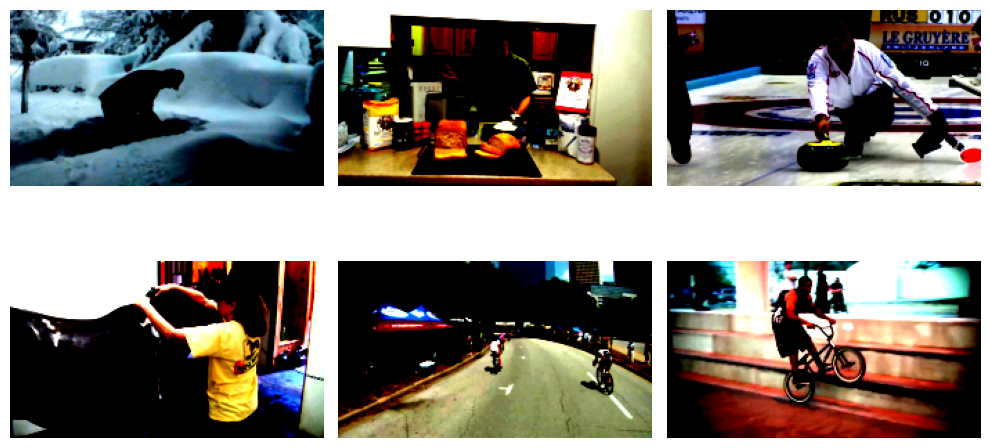

In [5]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        value = np.random.randint(len(dataset))
        image, _ = dataset[value]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_data, num_images=6)

In [6]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
    
            if current_count <= 400:
                needed = current_count * 3
            elif current_count <= 500:
                needed = current_count * 2
            elif current_count <= 1000:
                needed = current_count
            elif current_count <= 1200:
                needed = int(current_count * 0.5)
            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = list(np.random.choice(self.augmentations, size=num_augs, replace=False))
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)

Количество элементов по классам:
Класс 0: 2135 элементов
Класс 1: 446 элементов
Класс 2: 450 элементов
Класс 3: 1428 элементов
Класс 4: 639 элементов
Класс 5: 835 элементов
Класс 6: 680 элементов
Класс 7: 453 элементов
Класс 8: 1039 элементов
Класс 9: 449 элементов
Класс 10: 399 элементов
Класс 11: 376 элементов
Класс 12: 194 элементов
Класс 13: 640 элементов
Класс 14: 348 элементов


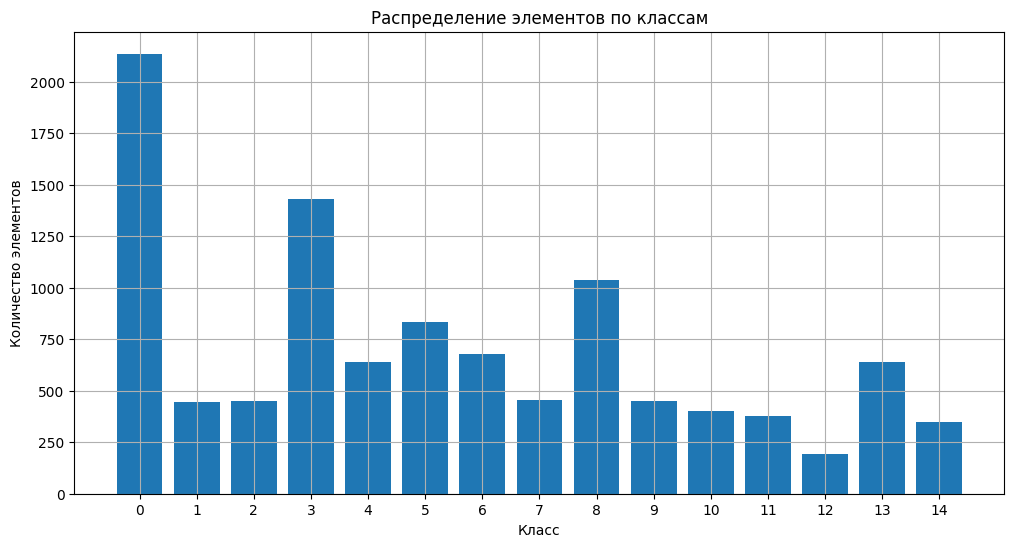

Количество элементов по классам:
Класс 0: 2135 элементов
Класс 1: 1338 элементов
Класс 2: 1350 элементов
Класс 3: 1428 элементов
Класс 4: 1278 элементов
Класс 5: 1670 элементов
Класс 6: 1360 элементов
Класс 7: 1359 элементов
Класс 8: 1558 элементов
Класс 9: 1347 элементов
Класс 10: 1596 элементов
Класс 11: 1504 элементов
Класс 12: 776 элементов
Класс 13: 1280 элементов
Класс 14: 1392 элементов


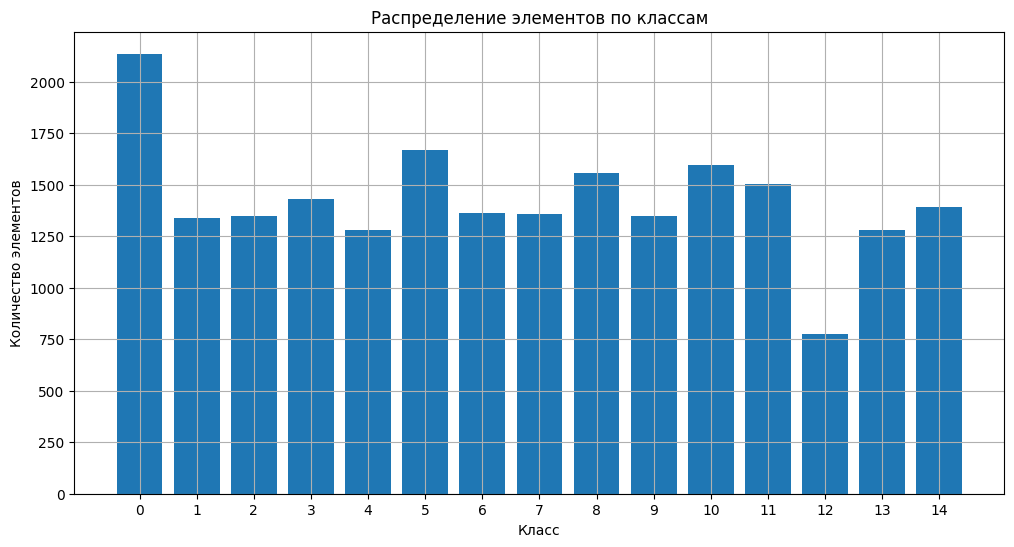

In [7]:
def count_classes(dataset):
    class_counts = defaultdict(int)
    
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    print("Количество элементов по классам:")
    for class_id in sorted(class_counts.keys()):
        print(f"Класс {class_id}: {class_counts[class_id]} элементов")
    
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Класс')
    plt.ylabel('Количество элементов')
    plt.title('Распределение элементов по классам')
    plt.xticks(list(class_counts.keys()))
    plt.grid(True)
    plt.show()

class_counts = count_classes(train_set)
class_counts = count_classes(balanced_train_set)

In [8]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return nn.ReLU()(out)

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=16):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
        self.to(device)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, stride=1)
        )

    def forward(self, x):
        x = x.to(device)
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SimpleResNet(16).to(device)
summary(model, (3, 128, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 114]           9,472
       BatchNorm2d-2          [-1, 64, 64, 114]             128
              ReLU-3          [-1, 64, 64, 114]               0
         MaxPool2d-4           [-1, 64, 32, 57]               0
            Conv2d-5           [-1, 64, 32, 57]          36,928
       BatchNorm2d-6           [-1, 64, 32, 57]             128
            Conv2d-7           [-1, 64, 32, 57]          36,928
       BatchNorm2d-8           [-1, 64, 32, 57]             128
     ResidualBlock-9           [-1, 64, 32, 57]               0
           Conv2d-10           [-1, 64, 32, 57]          36,928
      BatchNorm2d-11           [-1, 64, 32, 57]             128
           Conv2d-12           [-1, 64, 32, 57]          36,928
      BatchNorm2d-13           [-1, 64, 32, 57]             128
    ResidualBlock-14           [-1, 64,

In [14]:
def run_epoch(model, dataloader, loss_function, optimizer=None, device=None):
    """Выполняет одну эпоху обучения/валидации"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.train(mode=optimizer is not None)
    total_loss = 0.0
    all_preds, all_targets = [], []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader, desc=f"{'Training' if optimizer else 'Evaluating'}"):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)
            total_loss += loss.item()
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)  # Вычисляем вне условий
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1_val = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1_val
    
    return avg_loss, None, None  # Всегда возвращаем avg_loss

In [16]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [17]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

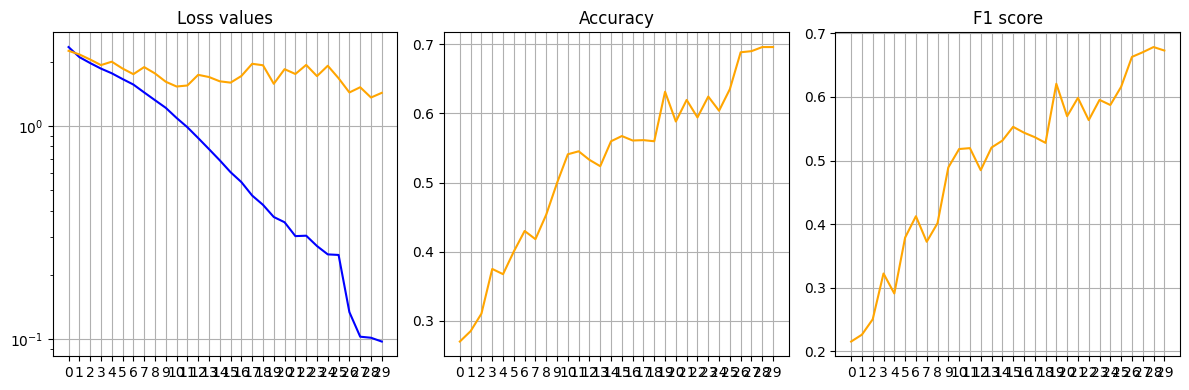


Best results:
Min loss: 1.3567
Max Accuracy: 0.6961
Max F1: 0.6785


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

NUM_EPOCHS = 30

# Инициализация модели и оптимизатора
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-4)

# Инициализация scheduler
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',   
    factor=0.5,   
    patience=5,   
    verbose=True,  
    min_lr=1e-6   
)

train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []
best_f1 = -np.inf  

for epoch in range(NUM_EPOCHS):
    train_loss, _, _ = run_epoch(model, train_loader, loss_function, optimizer, device)
    train_loss_hist.append(train_loss)
    
    with torch.no_grad():
        test_loss, acc, f1_val = run_epoch(model, valid_loader, loss_function, None, device)
        test_loss_hist.append(test_loss)
        accuracy.append(acc)
        f1.append(f1_val)
    
    scheduler.step(f1[-1])  
    
    if f1[-1] > best_f1:
        best_f1 = f1[-1]
        torch.save(model, 'model4_16_best_model.pth')
        torch.save(model.state_dict(), 'model4_16_best_weights.pth')
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.2e}")
    
    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)

print(f"\nBest results:")
print(f"Min loss: {min(test_loss_hist):.4f}")
print(f"Max Accuracy: {max(accuracy):.4f}")
print(f"Max F1: {best_f1:.4f}")

In [ ]:
model = torch.load('model4_16_best_model.pth', weights_only=False)
model.load_state_dict(torch.load('model4_16_best_weights.pth'))
model = model.to(device)

for epoch in range(NUM_EPOCHS):
    train_loss, _, _ = run_epoch(model, train_loader, loss_function, optimizer, device)
    train_loss_hist.append(train_loss)
    
    with torch.no_grad():
        test_loss, acc, f1_val = run_epoch(model, valid_loader, loss_function, None, device)
        test_loss_hist.append(test_loss)
        accuracy.append(acc)
        f1.append(f1_val)
    
    scheduler.step(f1[-1])  
    
    if f1[-1] > best_f1:
        best_f1 = f1[-1]
        torch.save(model, 'model4_16_best_model.pth')
        torch.save(model.state_dict(), 'model4_16_best_weights.pth')
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.2e}")
    
    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)

print(f"\nBest results:")
print(f"Min loss: {min(test_loss_hist):.4f}")
print(f"Max Accuracy: {max(accuracy):.4f}")
print(f"Max F1: {best_f1:.4f}")

Training:  82%|████████▏ | 137/167 [11:27<02:48,  5.60s/it]

In [19]:
from sklearn.metrics import classification_report
model = torch.load('model4_16_best_model.pth', weights_only=False)
model.load_state_dict(torch.load('model4_16_best_weights.pth'))
model = model.to(device)

y_true, y_pred = predict(model, valid_loader)
print(classification_report(y_true, y_pred))

100%|██████████| 15/15 [00:38<00:00,  2.58s/it]

              precision    recall  f1-score   support

           0       0.72      0.81      0.77       377
           1       0.55      0.48      0.51        79
           2       0.42      0.57      0.49        80
           3       0.60      0.68      0.64       252
           4       0.68      0.74      0.71       113
           5       0.77      0.64      0.70       147
           6       0.77      0.70      0.73       120
           7       0.77      0.71      0.74        80
           8       0.82      0.68      0.75       184
           9       0.64      0.71      0.67        79
          10       0.86      0.89      0.87        70
          11       0.56      0.42      0.48        66
          12       0.60      0.53      0.56        34
          13       0.79      0.62      0.69       113
          14       0.93      0.81      0.86        62

    accuracy                           0.70      1856
   macro avg       0.70      0.67      0.68      1856
weighted avg       0.71   

In [20]:
model = torch.load('model4_16_best_model.pth', weights_only=False)
model.load_state_dict(torch.load('model4_16_best_weights.pth'))
model = model.to(device)
model.eval()

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Подготовка для сохранения предсказаний
test_preds = []
test_ids = []

# Предсказание на тестовых данных
with torch.no_grad():
    for img_name in tqdm(test_set.image_files, desc="Processing test images"):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
        
        output = model(image)
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])  # Извлекаем ID без расширения
        test_preds.append(pred.item())

original_labels = le.inverse_transform(test_preds)

# Сортируем по ID (если нужно)
test_ids, test_preds = zip(*sorted(zip(test_ids, original_labels), key=lambda x: int(x[0])))

# Сохраняем в CSV
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))

print(f"Predictions saved to submission.csv, total {len(test_preds)} predictions")

Processing test images: 100%|██████████| 5301/5301 [05:08<00:00, 17.18it/s]

Predictions saved to submission.csv, total 5301 predictions
